```
# Team
- Rahul Vigneswaran K | CS23MTECH02002
```

# Assignment 4

## Assumption
1. Rak of A is n

Implement the simplex algorithm to maximize the objective function, You need to implement the method discussed in class.

##Input
- CSV file with m+1 rows and n+1 column.
- The first row excluding the last element is the cost vector c of length n
- The last column excluding the top element is the constraint vector b of length m
- Rows two to m+1 and column one to n is the matrix A of size m*n

##Output
You need to print the sequence of vertices visited and the value of the objective function at that vertex.



# Required Functions


## imports

In [133]:
import csv
import random
import numpy as np
from scipy.linalg import null_space
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
np.random.seed(0)

## read_data
This function facilitates the reading of a CSV file and retrieves the values stored within columns A, z, b, and c.

In [134]:
# reads data from csv
def read_data(filename, initial_point_given = True):
  """
  Reads data from a CSV file and extracts z, c, b, and A matrices.
  """
  with open(filename, newline='') as csvfile:
      reader = csv.reader(csvfile)
      data = list(reader)

  if initial_point_given:
    # Extract z (initial feasible point) and c (cost vector)
    z = np.array([float(val) for val in data[0][:-1]])  # Excluding the last element (empty string)
    c = np.array([float(val) for val in data[1][:-1]])  # Excluding the last element (empty string)

    # Extract b (constraint vector)
    b = np.array([float(row[-1]) for row in data[2:]])  # Last column excluding first two rows

    # Extract A (matrix A)
    A = np.array([[float(val) for val in row[:-1]] for row in data[2:]])  # Excluding the last element (constraint column)

    return A, z, b, c
  else:
    # Extract z (initial feasible point) and c (cost vector)
    c = np.array([float(val) for val in data[0][:-1]])  # Excluding the last element (empty string)

    # Extract b (constraint vector)
    b = np.array([float(row[-1]) for row in data[1:]])  # Last column excluding first two rows

    # Extract A (matrix A)
    A = np.array([[float(val) for val in row[:-1]] for row in data[1:]])  # Excluding the last element (constraint column)

    return A, b, c

## find_tight_rows
This function analyzes the given inputs (A, z, b) to distinguish between tight and untight rows, generating a mask to indicate their classification. It then returns both the identified rows and the corresponding mask for further analysis or processing.

In [135]:
def find_tight_rows(_A, _z, _b, epi=1e-8):
  # the following do multiplication of Z with the corresponding A.
  product = np.dot(_A, _z)

  # Check if the product equals b_i for each row. This will also give us a TRUE/FALSE mask of the tight rows
  tight_mask = np.abs(product - _b) < epi #this is done to prevent rounding errors in 3D cases
  A1 = _A[tight_mask]
  A2 = _A[~tight_mask]
  return tight_mask, A1, A2

## get_directions
This function determines the directional guidance towards the closest vertices. Its calculation involves determining the inverse of -A represented as $-A^{-1}$.

In [136]:
def get_directions(_A1):
  try:
    # Calculate the inverse of matrix A
    A_inv = np.linalg.inv(_A1)

    # Multiply the inverse by -1
    neg_A_inv = -1 * A_inv

    return neg_A_inv

  except np.linalg.LinAlgError:
    # Handling the case where the matrix is singular (non-invertible)
    print("Matrix is singular. Cannot compute the inverse.")
    return None

# is_degenerate
Checks if the given point is degenerate by comparing the tight row matrix's rows and column.

In [137]:
def is_degenerate(tight):
  return tight.shape[0] > tight.shape[1]

# make_non_degenerate
Makes the point non-degenerate by doing $(b_1 + \epsilon^1), (b_2 + \epsilon^2) ... , (b_i + \epsilon^i)$.

In [138]:
def make_non_degenerate(vector_b_original, epi, reduction_factor=0.5):
  epi = epi*reduction_factor
  new_b  = np.array([vector_b_original[i]+epi**(i+1) for i in range(len(vector_b_original))])
  return new_b, epi

## get_modified_LP
This function modifies the LP by adding a new row and column to the existing LP in such a way that the optimal solution of this modified LP is the initial feasible point of the old LP.

In [139]:
def get_modified_LP(_A, _b, _c):
  # Finding the minimum value in b
  min_b = min(_b)

  # Initializing the initial point with the minimum value found
  initial_point = np.zeros((_A.shape[1] + 1, 1))
  initial_point[-1] = min_b

  # Renaming variables for clarity
  modified_A, modified_b, modified_c = _A, _b, _c

  # Check and modify matrices if necessary
  if initial_point.shape != _c.shape:
    rows, cols = _A.shape
    modified_A = np.append(np.append(_A, np.zeros((1, cols)), axis=0), np.ones((rows + 1, 1)), axis=1)
    modified_A[-1][-1] = -1

    # Adjusting b and c matrices
    modified_b = np.append(_b, [abs(min(_b))], axis=0)
    modified_c = np.zeros((cols + 1, 1))
    modified_c[-1] = 1

  return modified_A, modified_b, np.hstack(modified_c), np.hstack(initial_point)

## feasible_to_vertex_assign4
This function serves to transform an initial feasible point into a vertex through two distinct cases:
- Case 1 : Full Rank Tight Row Matrix:
  - If the tight row matrix is full rank, the initial feasible point is already a vertex.
- Case 2 : Non-Full Rank Tight Row Matrix:
  - To move towards a vertex, a direction and magnitude are essential.
    - Direction ($u$): Computed as a vector from the null space of the tight row matrix. In the absence of tight rows, a random vector of the same shape is utilized.
      - __Handling unbounded case__: If there is no positive $\alpha$, then use $-u$.
    - Magnitude ($\alpha$):
      - $\alpha = \min_{t} \frac{b_t - A_tx_o}{A_t-u}$
      , where $A$ represents the matrix of all non-tight rows.
        - __Handling unbounded case__: If there is no positive $\alpha$, then re-calculate with $-u$.
  - The updated point is computed as: $z_{\text{new}} = z + \alpha u$.
  - This process iterates until the tight rows attain full rank.

In [140]:
def feasible_to_vertex_assign4(_matrix_A, _vector_b, _vector_z, _vector_c, _dimension_n):
  # Track variables
  track_cost = []
  track_z = []
  track_cost.append(np.dot(_vector_c, _vector_z))
  track_z.append(_vector_z)

  # Initialize variables for iteration
  z_old = _vector_z
  iteration = 0
  print_interval = 1

  mask, tight_rows, untight_rows = find_tight_rows(_matrix_A, _vector_z, _vector_b)

  if len(tight_rows) == 0:
      rank = 0
  else:
      rank = np.linalg.matrix_rank(tight_rows)

  if rank == _dimension_n:
      return z_old, track_cost, track_z
  else:
    print("Feasible point is not a vertex. Searching for a vertex...")
    print("==================================================")

  while rank != _dimension_n:
    iteration += 1

    # Display iteration information
    if iteration % print_interval == 0:
        print(f"Iteration: {iteration} - Rank: {rank}")
        if iteration > 300:
          print_interval = 1000
        elif iteration > 10000:
          print_interval = 10000

    # Determine direction to move in
    if len(tight_rows) == 0:
        u = np.random.rand(untight_rows.shape[-1])
    else:
        null_space_matrix = null_space(tight_rows)
        u = null_space_matrix[:, 0]

    # Calculate step magnitude
    while True:
      # Calculate step magnitude
      alphas = [(_b_i - np.dot(a2_i, z_old)) / np.dot(a2_i, u) for _b_i, a2_i in zip(_vector_b[~mask], untight_rows)]
      alphas = [alpha for alpha in alphas if alpha > 0]

      positive_alphas = []
      epi = 1e-10 #to prevent underflow/overflow errors
      for i in alphas:
        if not(i == np.inf or abs(i) < epi):
          positive_alphas.append(i)

      if len(positive_alphas) == 0:
        u = -1*u
      else:
        break

    alpha = min(positive_alphas)

    # Move to the new vertex
    z_new = z_old + alpha * u

    # Update tight and untight rows based on the new vertex
    mask, tight_rows, untight_rows = find_tight_rows(_matrix_A, z_new, _vector_b)

    z_old = z_new

    # Recalculate rank based on updated tight rows
    if len(tight_rows) == 0:
        rank = 0
    else:
        rank = np.linalg.matrix_rank(tight_rows)

    # Store the newly found vertex
    track_cost.append(np.dot(_vector_c, z_new))
    track_z.append(z_new)

  if not(is_degenerate(tight_rows)):
    return (z_new, track_cost, track_z)
  else:
    return (None,)

## vertex_to_vertex_assign4
This function employs Vertex Marching to search for the maximum optimal vertex based on a given vertex. The process involves using all tight rows represented by $A$ to calculate $-A^{-1}$, where each column in the resulting matrix signifies a direction to the nearest vertex.

- Case 1: Check for Optimality:
    - We take the columns of $-A^{-1}$, denoted as $u$, and assess whether the dot product of $u$ and $c$ is positive. If none of the columns' dot products are positive:
      - The current vertex stands as the optimal vertex.
- Case 2: Move towards a Vertex:
  - When a positive direction exists among the columns of $-A^{-1}$ (represented as $u$ and checked against $c$):
    - To proceed towards a vertex, determining direction and magnitude is necessary.
      - Direction ($u$): This is same as the previously identified positive direction.
      - Magnitude ($\alpha$):
        - $\alpha = \min_{t} \frac{b_t - A_tx_o}{A_t - u}$. Here, $A$ refers to the matrix of all non-tight rows.
          - __Handling unbounded case__: If there is no positive $\alpha$, that means the problem is unbounded. In this case, we just return the vertices we have visited so far with corresponding cost and print that the problem is unbounded.
    - Update the point as: $z_{\text{new}} = z + \alpha u$.
    - Iterate this process until no positive directions remain.

In [141]:
def vertex_to_vertex_assign4(_matrix_A, _vector_b, _vector_z, _vector_c, _columns):
  # Track variables
  track_cost = []
  track_vertex = []

  # Initialize variables
  z_old = _vector_z
  z_new = z_old
  track_cost.append(np.dot(_vector_c, z_old))
  track_vertex.append(z_old)
  iteration = 0
  print_interval = 1

  while True:
    iteration += 1
    # Display iteration information
    if iteration % print_interval == 0:
      print(f"Iteration: {iteration}")

    # Find tight and untight rows
    mask, tight_rows, untight_rows = find_tight_rows(_matrix_A, z_old, _vector_b)

    # handling degeneracy
    if is_degenerate(tight_rows):
      return (None,)

    # Get directions
    directions = get_directions(tight_rows).T

    # Get positive directions to move in
    positive_directions = []
    for direction in directions:
      if np.dot(direction, _vector_c) > 0:
          positive_directions.append(direction)

    if not positive_directions or iteration > 10:
      return z_new, track_cost, track_vertex

    u = positive_directions[0]  # Select a positive direction

    # Calculate step size
    alphas = [(b_i - np.dot(a2_i, z_old)) / np.dot(a2_i, u) for b_i, a2_i in zip(_vector_b[~mask], untight_rows)]
    alphas = [alpha for alpha in alphas if alpha > 0]

    positive_alphas = []
    epi = 1e-10 # to prevent underflow/overflow errors
    for i in alphas:
      if not(i == np.inf or abs(i) < epi):
        positive_alphas.append(i)

    if len(positive_alphas) == 0 : # Handling unbounded case
      print(f"The problem is unbounded. Can't find a optimal solution!")
      return None, track_cost, track_vertex

    alpha = min(positive_alphas)

    z_new = z_old + alpha * u
    z_old = z_new

    # Calculate cost of current vertex
    track_cost.append(np.dot(_vector_c, z_new))
    track_vertex.append(z_new)

## find_initial_feasible point
This function when provided with `A,b,c` will output a initial feasible point.
- Case 1: All `b` are non_negative
  - If this is the case then the 0 origin is the initial feasible point
- Case 2: Atleast one `b` is negative
  - Then we modify the LP and find the optimal solution for the modified LP. This will be the initial feasible point of the original problem.

In [142]:
def find_initial_feasible_point(A, b, c):
    origin_feas = False
    if np.all(b >= 0):
        origin_feas = True
        z = np.zeros(c.shape)
        print("Using 0 origin as the initial feasible point!")
        return (z,)
    else:
        _A, _b, _c, _z = get_modified_LP(A, b, c)
        _m, _n = len(_b), len(_c)

        # Display extracted data
        print("Initial Feasible Point (z):", _z)
        print("Cost Vector (c):", _c)
        print("Constraint Vector (b):", _b)
        print("Matrix A:")
        print(_A)
        print(f"Rows: {_m} | Columns: {_n}")

        if not(origin_feas):
            print("\n==================================================")
            print("Solving the modified LP!")
            print("==================================================\n")
            matrix_A = _A
            vector_b_original = _b
            vector_z = _z
            vector_c = _c
            dimension_n = _n

            epsilon = 0.1
            attempt = 0
            vector_b = vector_b_original
            attempt = 0
            while True:
                if attempt > 0:
                    print("\n==================================================")
                    print(f"Degeneracy detected. Attempting to handle it. Attempt - {attempt}")
                    print("==================================================\n")
                    vector_b, epsilon = make_non_degenerate(vector_b_original, epsilon)

                outputs1 = feasible_to_vertex_assign4(matrix_A, vector_b, vector_z, vector_c, dimension_n)
                if len(outputs1) == 1:
                    attempt += 1
                    continue

                print("\n==================================================")
                print("Reached the initial vertex from feasible point!")
                print("==================================================\n")
                z_new, feas2vert_z_all_cost, feas2vert_z_all = outputs1

                print("Searching for optimal vertex...")
                print("==================================================")
                outputs2 = vertex_to_vertex_assign4(matrix_A, vector_b, z_new, vector_c, dimension_n)
                if len(outputs2) == 1:
                    attempt += 1
                    continue

                z_optimal, vert2vert_z_all_cost, vert2vert_z_all = outputs2
                if np.all(z_optimal == None):
                    modified_z_optimal = None
                else:
                    modified_z_optimal = -1  # some junk value
                if np.all(z_optimal == None):
                    print("\n==================================================")
                    print("The problem is unbounded!")
                    print("==================================================\n")
                else:
                    print("\n==================================================")
                    print("Reached the optimal vertex!")
                    print("==================================================\n")
                break
            if modified_z_optimal == None:
                print("\n==================================================")
                print("The modified LP is unbounded! Therefore the given problem is unbounded!")
                print("==================================================\n")
            else:
                z = z_optimal[:n]
                print("\n==================================================")
                print("The following is the initial feasible point for the original problem:")
                print(z)
                print("==================================================\n")
    return (z_optimal, modified_z_optimal, z_new, feas2vert_z_all_cost, feas2vert_z_all, z_optimal, vert2vert_z_all_cost, vert2vert_z_all)

# Main
## Sample test cases
- `testcase_5.csv` : Without inital feasible point, Non-degenerate, Bounded. All positive b. SAME AS testcase_1.csv but without the 1st row. https://www.desmos.com/calculator/3pscsowphb
- `testcase_6.csv` : Without inital feasible point, Non-degenerate, Bounded. Atleast one -ve b. https://www.desmos.com/calculator/zwfsdzbrk0

- `testcase_7.csv` : Without inital feasible point, Non-degenerate, Unbounded. All positive b. SAME AS testcase_2.csv but without the 1st row. https://www.desmos.com/calculator/mgfg9jhofq

- `testcase_8.csv` : Without inital feasible point, Non-degenerate, Unbounded. Atleast one -ve b. https://www.desmos.com/calculator/kboknzaxln

- `testcase_9.csv` : Without inital feasible point, Degenerate, Bounded. All positive b. SAME AS testcase_3.csv but without the 1st row. https://www.desmos.com/calculator/06uocynnxe
- `testcase_10.csv` : Without inital feasible point, Degenerate, Bounded. Atleast one -ve b. https://www.desmos.com/calculator/hkczrfpjny

- `testcase_11.csv` : Without inital feasible point, Degenerate, Unbounded. All positive b. SAME AS testcase_4.csv but without the 1st row. https://www.desmos.com/calculator/04h97moxit
- `testcase_12.csv` : Without inital feasible point, Degenerate, Unbounded. Atleast one -ve b. https://www.desmos.com/calculator/ix2fiu9gva

|                 |        |
|-----------------|--------|
| **Test Case 5** | PASS   |
| **Test Case 6** | PASS   |
| **Test Case 7** | PASS   |
| **Test Case 8** | PASS   |
| **Test Case 9** | PASS   |
| **Test Case 10**| PASS   |
| **Test Case 11**| PASS   |
| **Test Case 12**| PASS   |


## Reading the input

In [143]:
A, b, c = read_data('testcase_12.csv', initial_point_given=False)
m, n = len(b), len(c)

# Display extracted data
print("Cost Vector (c):", c)
print("Constraint Vector (b):", b)
print("Matrix A:")
print(A)
print(f"Rows: {m} | Columns: {n}")

Cost Vector (c): [5. 2.]
Constraint Vector (b): [  1.   -1.  -10.   -5.6]
Matrix A:
[[ 0.  -1. ]
 [-1.   0. ]
 [-1.  -1. ]
 [-0.6 -1. ]]
Rows: 4 | Columns: 2


# Getting initial feasible point


In [144]:
outputs = find_initial_feasible_point(A, b, c)
if len(outputs) > 1:
  z_optimal, modified_z_optimal, z_new, feas2vert_z_all_cost, feas2vert_z_all, z_optimal, vert2vert_z_all_cost, vert2vert_z_all = outputs
  if modified_z_optimal != None:
    z = z_optimal[:len(c)]
else:
  z = outputs[0]
  modified_z_optimal = -1

Initial Feasible Point (z): [  0.   0. -10.]
Cost Vector (c): [0. 0. 1.]
Constraint Vector (b): [  1.   -1.  -10.   -5.6  10. ]
Matrix A:
[[ 0.  -1.   1. ]
 [-1.   0.   1. ]
 [-1.  -1.   1. ]
 [-0.6 -1.   1. ]
 [ 0.   0.  -1. ]]
Rows: 5 | Columns: 3

Solving the modified LP!

Feasible point is not a vertex. Searching for a vertex...
Iteration: 1 - Rank: 2

Degeneracy detected. Attempting to handle it. Attempt - 1

Feasible point is not a vertex. Searching for a vertex...
Iteration: 1 - Rank: 0
Iteration: 2 - Rank: 1
Iteration: 3 - Rank: 2

Reached the initial vertex from feasible point!

Searching for optimal vertex...
Iteration: 1
The problem is unbounded. Can't find a optimal solution!

The problem is unbounded!


The modified LP is unbounded! Therefore the given problem is unbounded!



<ipython-input-140-5aa2edb2fc4b>:47: RuntimeWarning: divide by zero encountered in double_scalars
  alphas = [(_b_i - np.dot(a2_i, z_old)) / np.dot(a2_i, u) for _b_i, a2_i in zip(_vector_b[~mask], untight_rows)]


## Handling degeneracy
If the tight row matrix has more rows than columns, this indicates degeneracy. To fix this,
  - We add a small perturbation to the $b_i$ like, $(b_1 + \epsilon^1), (b_2 + \epsilon^2) ... , (b_i + \epsilon^i)$
  - Then we run the `feasible_to_vertex_assign3` and `vertex_to_vertex_assign3` sub-routines.  If at some intermediate step, we detect degeneracy again, we go back to the first step, reduce the epsilon and restart everything from the beginning.

In [145]:
if modified_z_optimal == None:
    print("\n==================================================")
    print("The problem is unbounded!")
    print("==================================================\n")
else:
  matrix_A = A
  vector_b_original = b
  vector_z = z
  vector_c = c
  dimension_n = n

  epsilon = 0.1
  attempt = 0
  vector_b = vector_b_original
  attempt = 0
  while True:
    if attempt > 0:
      print("\n==================================================")
      print(f"Degeneracy detected. Attempting to handle it. Attempt - {attempt}")
      print("==================================================\n")
      vector_b, epsilon = make_non_degenerate(vector_b_original, epsilon)

    outputs1 = feasible_to_vertex_assign4(matrix_A, vector_b, vector_z, vector_c, dimension_n)
    if len(outputs1) == 1:
      attempt+=1
      continue

    print("\n==================================================")
    print("Reached the initial vertex from feasible point!")
    print("==================================================\n")
    z_new, feas2vert_z_all_cost, feas2vert_z_all = outputs1

    print("Searching for optimal vertex...")
    print("==================================================")
    outputs2 = vertex_to_vertex_assign4(matrix_A, vector_b, z_new, vector_c, dimension_n)
    if len(outputs2) == 1:
      attempt+=1
      continue

    z_optimal, vert2vert_z_all_cost, vert2vert_z_all = outputs2
    if np.all(z_optimal == None):
      print("\n==================================================")
      print("The problem is unbounded!")
      print("==================================================\n")
    else:
      print("\n==================================================")
      print("Reached the optimal vertex!")
      print("==================================================\n")
    break


The problem is unbounded!



In [146]:
if modified_z_optimal == None:
  print("\n==================================================")
  print("The problem is unbounded! \nSo we are displaying the values for the modified LP which was used to find the initial feasible point!")
  print("==================================================\n")

print("==========================")
print("Feasible point to vertex")
print("==========================")
print(f"Point: {feas2vert_z_all}")
print(f"Cost: {feas2vert_z_all_cost}")

print("\nInitial vertex")
print("==========================")

print(z_new)


print("\n==========================")
print("Vertex to Optimal vertex")
print("==========================")

print(f"Point: {vert2vert_z_all}")
print(f"Cost: {vert2vert_z_all_cost}")

if np.all(z_optimal == None):
  print("\nThe problem is unbounded!")
else:
  print("\nOptimal vertex")
print("==========================")
print(z_optimal)


The problem is unbounded! 
So we are displaying the values for the modified LP which was used to find the initial feasible point!

Feasible point to vertex
Point: [array([  0.,   0., -10.]), array([ 91.57933787, 119.34212288,  90.58183787]), array([91.57933787, 89.53183787, 90.58183787]), array([11.08332292,  9.03582292, 10.08582292])]
Cost: [-10.0, 90.5818378692185, 90.5818378692185, 10.085822916666615]

Initial vertex
[11.08332292  9.03582292 10.08582292]

Vertex to Optimal vertex
Point: [array([11.08332292,  9.03582292, 10.08582292])]
Cost: [10.085822916666615]

The problem is unbounded!
None


### Visualizing the feasible point to vertex journey
> WARNING: Skip this if the input is very large as it involves TSNE and that might take a long time for such inputs.

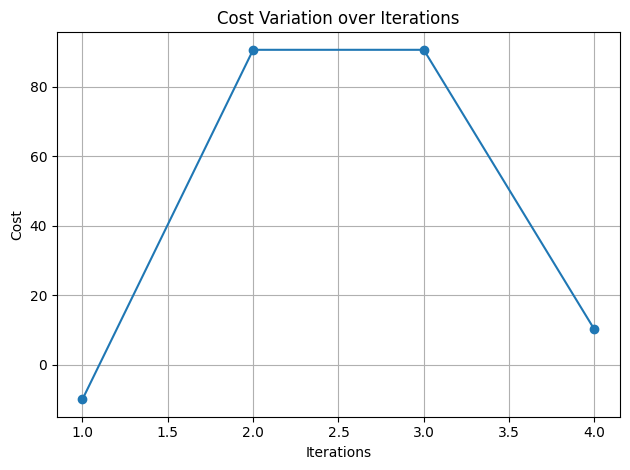

In [147]:
# Plotting the costs against iterations
iterations = range(1, len(feas2vert_z_all_cost) + 1)
plt.plot(iterations, feas2vert_z_all_cost, marker='o')

# Adding labels and title
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost Variation over Iterations')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

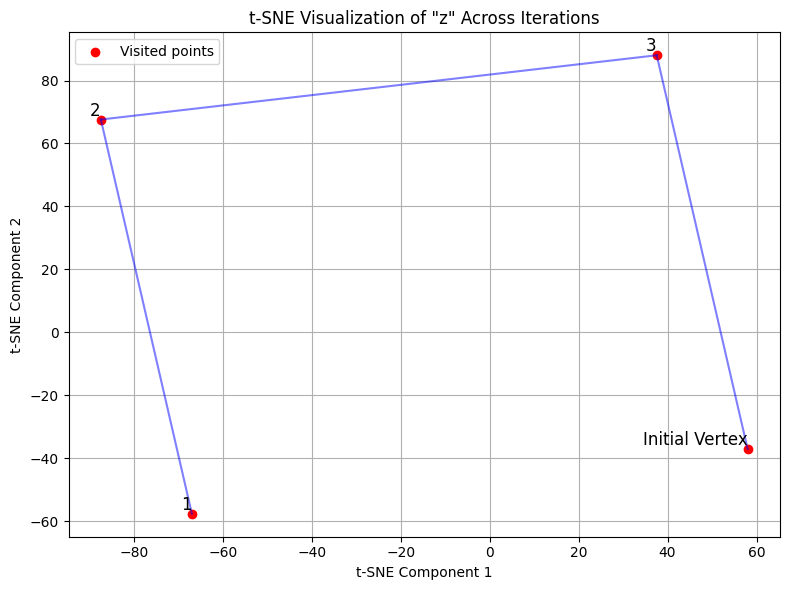

In [148]:
vectors = np.stack(feas2vert_z_all)

if len(vectors) > 1:
  # Perform t-SNE to reduce the vectors to a 2-dimensional space
  tsne = TSNE(n_components=2, random_state=42, perplexity=len(vectors) - 1)
  vectors_2d = tsne.fit_transform(vectors)

  # Plot the vectors in the 2D t-SNE space and connect them across iterations
  plt.figure(figsize=(8, 6))
  for i in range(len(vectors_2d) - 1):
      plt.plot(
          [vectors_2d[i][0], vectors_2d[i + 1][0]],
          [vectors_2d[i][1], vectors_2d[i + 1][1]],
          'b-',
          alpha=0.5
      )
      plt.scatter(vectors_2d[i][0], vectors_2d[i][1], color='red')
      plt.text(
          vectors_2d[i][0],
          vectors_2d[i][1],
          str(i + 1),
          horizontalalignment='right',
          verticalalignment='bottom',
          fontsize=12,
          color='black'
      )

  # Plot the last vector separately to avoid connecting it to the next iteration
  plt.scatter(vectors_2d[-1][0], vectors_2d[-1][1], color='red', label='Visited points')
  plt.text(
      vectors_2d[-1][0],
      vectors_2d[-1][1],
      "Initial Vertex",
      horizontalalignment='right',
      verticalalignment='bottom',
      fontsize=12,
      color='black'
  )

  # Set labels and title
  plt.xlabel('t-SNE Component 1')
  plt.ylabel('t-SNE Component 2')
  plt.title('t-SNE Visualization of "z" Across Iterations')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()

  # Show the plot
  plt.show()
else:
  print("Cant plot TSNE as there is only one vector!")

### Visualizing the vertex to optimal vertex path
> WARNING: Skip this if the input is very large as it involves TSNE and that might take a long time for such inputs.

The problem is unbounded!


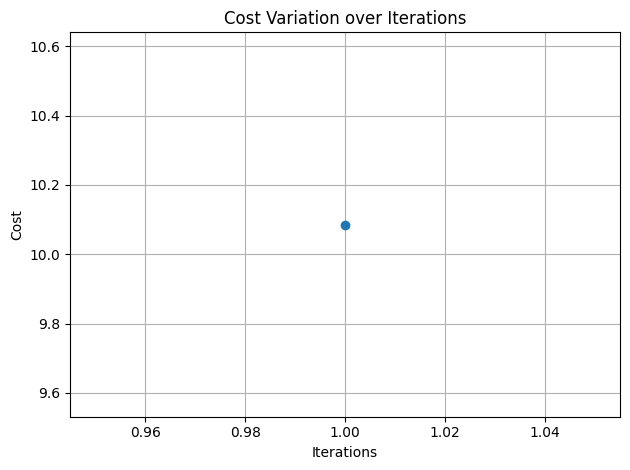

In [149]:
if np.all(z_optimal == None):
  print("The problem is unbounded!")

# Plotting the costs against iterations
iterations = range(1, len(vert2vert_z_all_cost) + 1)
plt.plot(iterations, vert2vert_z_all_cost, marker='o')

# Adding labels and title
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost Variation over Iterations')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [150]:
if np.all(z_optimal == None):
  print("The problem is unbounded!")
  final_point = "Vertex"
else:
  final_point = "Optimal Vertex"

vectors = np.stack(vert2vert_z_all)

if len(vectors) > 1:
  # Perform t-SNE to reduce the vectors to a 2-dimensional space
  tsne = TSNE(n_components=2, random_state=42, perplexity=len(vectors) - 1)
  vectors_2d = tsne.fit_transform(vectors)

  # Plot the vectors in the 2D t-SNE space and connect them across iterations
  plt.figure(figsize=(8, 6))
  for i in range(len(vectors_2d) - 1):
      plt.plot(
          [vectors_2d[i][0], vectors_2d[i + 1][0]],
          [vectors_2d[i][1], vectors_2d[i + 1][1]],
          'b-',
          alpha=0.5
      )
      plt.scatter(vectors_2d[i][0], vectors_2d[i][1], color='red')
      plt.text(
          vectors_2d[i][0],
          vectors_2d[i][1],
          str(i + 1),
          horizontalalignment='right',
          verticalalignment='bottom',
          fontsize=12,
          color='black'
      )

  # Plot the last vector separately to avoid connecting it to the next iteration
  plt.scatter(vectors_2d[-1][0], vectors_2d[-1][1], color='red', label='Visited Vertex')
  plt.text(
      vectors_2d[-1][0],
      vectors_2d[-1][1],
      final_point,
      horizontalalignment='right',
      verticalalignment='bottom',
      fontsize=12,
      color='black'
  )

  # Set labels and title
  plt.xlabel('t-SNE Component 1')
  plt.ylabel('t-SNE Component 2')
  plt.title('t-SNE Visualization of Vertices Across Iterations')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()

  # Show the plot
  plt.show()
else:
  print("Cant plot TSNE as there is only one vector!")

The problem is unbounded!
Cant plot TSNE as there is only one vector!
